In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

# from tensorflow.keras.optimizers import Adam

In [2]:
from tensorflow.keras.preprocessing.image import load_img ,img_to_array

# Load images (128, 128, 3)

path = "data/Dataset_BUSI_with_GT"

img_size = 128
X_b , Xm_b , y_b = np.zeros((437, img_size, img_size, 3)), np.zeros((437, img_size, img_size, 3)), np.full(437, 0) 
X_n , Xm_n , y_n = np.zeros((133, img_size, img_size, 3)), np.zeros((133, img_size, img_size, 3)), np.full(133, 1) 
X_m , Xm_m , y_m = np.zeros((210, img_size, img_size, 3)), np.zeros((210, img_size, img_size, 3)), np.full(210, 2)

# Read in malignant data
for file in os.listdir(os.path.join(path, 'malignant')): 
    if 'DS_Store' in file: 
        break
    if 'mask' in file: 
        if file[-5] == '1': 
            num = int(file.strip('malignant (').strip(')_mask_1.png'))
        else: 
            num = int(file.strip('malignant (').strip(')_mask.png'))
        Xm_m[num - 1] += img_to_array(load_img(os.path.join(path, 'malignant', file), target_size = (128, 128, 3)))
    else: 
        num = int(file.strip('malignant (').strip(').png'))
        X_m[num - 1] = img_to_array(load_img(os.path.join(path, 'malignant', file), target_size = (128, 128, 3)))
        
# Read in normal data
for file in os.listdir(os.path.join(path, 'normal')): 
    if 'DS_Store' in file: 
        break
    if 'mask' in file: 
        if file[-5] == '1': 
            num = int(file.strip('normal (').strip(')_mask_1.png'))
        else: 
            num = int(file.strip('normal (').strip(')_mask.png'))
        Xm_n[num - 1] += img_to_array(load_img(os.path.join(path, 'normal', file), target_size = (128, 128, 3)))
    else: 
        num = int(file.strip('normal (').strip(').png'))
        X_n[num - 1] = img_to_array(load_img(os.path.join(path, 'normal', file), target_size = (128, 128, 3)))
        
# Read in benign data
for file in os.listdir(os.path.join(path, 'benign')): 
    if 'DS_Store' in file: 
        break
    if 'mask' in file: 
        if file[-5] in ['1', '2']: 
            num = int(file.strip('benign (').strip('.png')[:-2].strip(')_mask'))
        else: 
            num = int(file.strip('benign (').strip(')_mask.png'))
        Xm_b[num - 1] += img_to_array(load_img(os.path.join(path, 'benign', file), target_size = (128, 128, 3)))
    else: 
        num = int(file.strip('benign (').strip(').png'))
        X_b[num - 1] = img_to_array(load_img(os.path.join(path, 'benign', file), target_size = (128, 128, 3)))

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Combine all data
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0, dtype = np.ndarray)

# Normalize the data
X /= 255.0
Xm /= 255.0

# Assign categorical vectors to y
y = to_categorical(y, num_classes = 3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, y, test_size = 0.3, shuffle = True, random_state = 42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(546, 128, 128, 3) (234, 128, 128, 3)
(546, 3) (234, 3)


In [12]:
def plot_model_parameters(history): 
    plt.figure(1, figsize = (20, 6))
    
    plt.subplot(121)
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize = 16)
    plt.ylabel('loss', fontsize = 16)
    plt.xlabel('epoch', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('accuracy', fontsize = 16)
    plt.xlabel('epoch', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
    
    plt.show()
    plt.savefig('loss_and_accuracy', dpi = 300)

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load in VGG-16 model with weights pre-trained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# Make sure the correct layers are frozen
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [6]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(3, activation = 'softmax')(x) # Softmax for multiclass

transfer_model = Model(inputs=vgg_model.input, outputs = x)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.6, 
                              patience = 8, 
                              verbose = 1, 
                              mode = 'max', 
                              min_lr = 5e-5)

checkpoint = ModelCheckpoint('vgg16_finetune.h15', 
                             monitor = 'val_accuracy', 
                             mode = 'max', 
                             save_best_only = True, 
                             verbose = 1)

In [8]:
from tensorflow.keras import layers, models, Model, optimizers

learning_rate = 5e-5

transfer_model.compile(loss = "categorical_crossentropy", 
                       optimizer = optimizers.Adam(lr = learning_rate), 
                       metrics = ["accuracy"])

history_vgg = transfer_model.fit(X_train, y_train, batch_size = 16, 
                                 epochs = 50, validation_data = (X_test,y_test), callbacks=[lr_reduce,checkpoint])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-10-16 20:25:08.799541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-16 20:25:08.800607: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


35/35 [==============================] - ETA: 0s - loss: 0.8351 - accuracy: 0.6494WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x32bf7db80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
35/35 [==============================] - 12s 326ms/step - loss: 0.8302 - accuracy: 0.6522 - val_loss: 0.4005 - val_accuracy: 0.8632

Epoch

/opt/homebrew/Caskroom/miniforge/base/envs/ml_work/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-10-16 20:25:20.813875: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/homebrew/Caskroom/miniforge/base/envs/ml_work/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
Epoch 2/50
35/35 [==============================] - 11s 310ms/step - loss: 0.4101 - accuracy: 0.8607 - val_loss: 0.3351 - val_accuracy: 0.8718

Epoch 00002: val_accuracy improved from 0.86325 to 0.87179, saving model to vgg16_finetune.h15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
Epoch 6/50
35/35 [==============================] - 12s 349ms/step - loss: 0.1245 - accuracy: 0.9603 - val_loss: 0.5020 - val_accuracy: 0.8846

Epoch 00006: val_accuracy did not improve from 0.91453
Epoch 7/50
35/35 [==============================] - 11s 311ms/step - loss: 0.1697 - accuracy: 0.9416 - val_loss: 0.4964 - val_accuracy: 0.8718

Epoch 00007: val_accuracy did not improve from 0.91453
Epoch 8/50
35/35 [==============================] - 11s 306ms/step - loss: 0.0951 - accuracy: 0.9613 - val_loss: 0.7432 - val_accuracy: 0.7735

Epoch 00008: val_accuracy did not improve from 0.91453
Epoch 9/50
35/35 [==============================] - 11s 302ms/step - loss: 0.1087 - accuracy: 0.9492 - val_loss: 0.459

35/35 [==============================] - 11s 303ms/step - loss: 0.0066 - accuracy: 0.9975 - val_loss: 0.9861 - val_accuracy: 0.9145

Epoch 00024: val_accuracy did not improve from 0.92735
Epoch 25/50
35/35 [==============================] - 11s 319ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.8030 - val_accuracy: 0.9231

Epoch 00025: val_accuracy did not improve from 0.92735
Epoch 26/50
35/35 [==============================] - 11s 315ms/step - loss: 0.0053 - accuracy: 0.9966 - val_loss: 1.2291 - val_accuracy: 0.8333

Epoch 00026: val_accuracy did not improve from 0.92735
Epoch 27/50
35/35 [==============================] - 11s 309ms/step - loss: 0.1953 - accuracy: 0.9521 - val_loss: 0.6723 - val_accuracy: 0.8889

Epoch 00027: val_accuracy did not improve from 0.92735
Epoch 28/50
35/35 [==============================] - 11s 302ms/step - loss: 0.0447 - accuracy: 0.9928 - val_loss: 0.9027 - val_accuracy: 0.8932

Epoch 00028: val_accuracy did not improve from 0.92735
Epoch 29/50


35/35 [==============================] - 11s 303ms/step - loss: 0.0023 - accuracy: 0.9984 - val_loss: 1.0854 - val_accuracy: 0.9145

Epoch 00046: val_accuracy did not improve from 0.93590
Epoch 47/50
35/35 [==============================] - 10s 302ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.1220 - val_accuracy: 0.9188

Epoch 00047: val_accuracy did not improve from 0.93590
Epoch 48/50
35/35 [==============================] - 11s 304ms/step - loss: 1.9039e-04 - accuracy: 1.0000 - val_loss: 1.1377 - val_accuracy: 0.9145

Epoch 00048: val_accuracy did not improve from 0.93590
Epoch 49/50
35/35 [==============================] - 11s 302ms/step - loss: 3.7980e-04 - accuracy: 0.9997 - val_loss: 1.1367 - val_accuracy: 0.9316

Epoch 00049: val_accuracy did not improve from 0.93590
Epoch 50/50
35/35 [==============================] - 11s 305ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 1.1556 - val_accuracy: 0.9316

Epoch 00050: val_accuracy did not improve from 0.93590


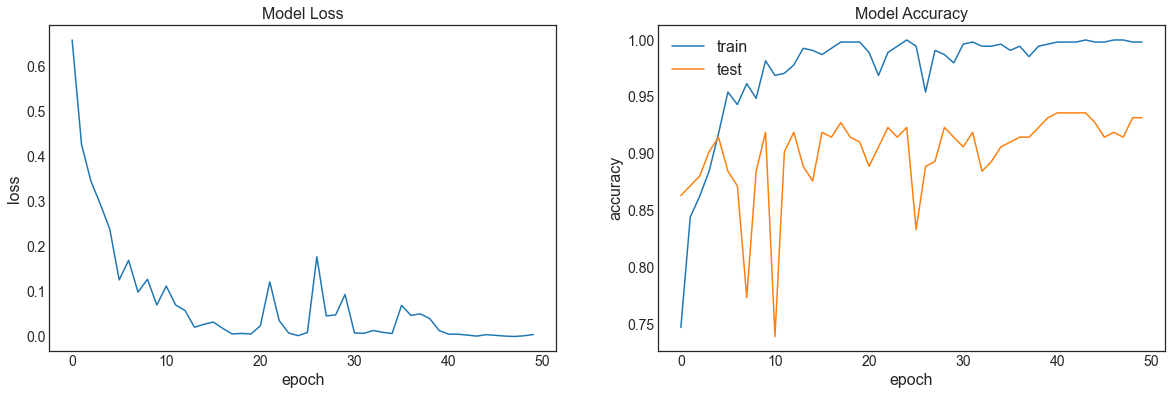

<Figure size 432x288 with 0 Axes>

In [13]:
plot_model_parameters(history_vgg)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


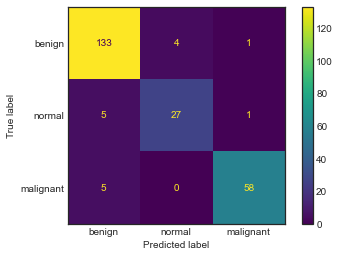

<Figure size 432x288 with 0 Axes>

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = transfer_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis = 1)
y_test_labels = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['benign', 'normal', 'malignant'])
disp.plot()
plt.show()
plt.savefig('confusion_matrix', dpi = 300)